PGL monitor calibration


In [1]:
%load_ext autoreload
%autoreload 2

# library imports
from matplotlib import pyplot as plt
import numpy as np

# Load PGL libraries and start a PGL window
from pgl import pgl as pglLibrary
pgl = pglLibrary()

# close any existing windows
pgl.cleanUp()

# open a new window
pgl.open(0,800,600)
pgl.visualAngle(57, 60,40)

================================ pglBase: init =================================
(pgl:checkOS) Python version: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:35:20) [Clang 16.0.6 ]
(pgl:checkOS) Running on MacBook Pro (MacBookPro18,3) with macOS version: 26.2
(pgl:checkOS) Apple M1 Pro Cores: 8 (6 performance and 2 efficiency) Memory: 32 GB
(pgl:checkOS) GPU: Apple M1 Pro (Built-In) 14 cores, Metal 4 support
(pgl:checkOS)   Color LCD [Main Display]: 3024 x 1964 Retina (Built-in Liquid Retina XDR Display) GammaTable size: 1024
(pgl:checkOS)   LED Cinema Display: 1920 x 1200 (WUXGA - Widescreen Ultra eXtended Graphics Array) (Unknown type) GammaTable size: 1024
(pglBase) Main library instance created
(pglBase:shutdownAll) Shutting down mglMetal process: 23586
(pglBase:removeOrphanedSockets) Removing orphaned socket: /Users/justin/Library/Containers/gru.mglMetal/Data/pglMetal.socket.20260210_143024.Z62QzZoWSp
(pglBase:removeOrphanedSockets) Removed 1 orphaned sockets
==========

Now, let's measure the temporal frequency response of the display using a photodiode. For this, you will need to do the following:

- Connect photodiode to Hamamatsu Amp via the BNC connector
- Connect the output of Hamamastu Amp to the Labjack A0 input
- Connect the USB of the Labjack to the computer
- Position the photodiode so that it is on the monitor


The following code will init the LabJack. Take a look at the output and make sure that it does not report an error loading LabJack.

In [2]:
# import pglLabJack and create an instance
from pgl import pglLabJack
pglLabJack = pglLabJack()

(pglLabJack) Opened T7 LabJack device via USB connection.
             serialNumber: 470040275 ipAddress: 0 port: 0 maxBytesPerMB: 64


We now will flicker the screen and display the output

(pglLabJack:setupDigitalOutput) Error setting up FIO0: LJM library error code 1294 LJME_INVALID_NAME: [FIO0_DIRECTION]
(pgl:_resolution:getResolution) Display 1/2: 1920x1200 60Hz 32bits
(pglLabJack:getCycles) Ignoring first 0.4s (400 samples)


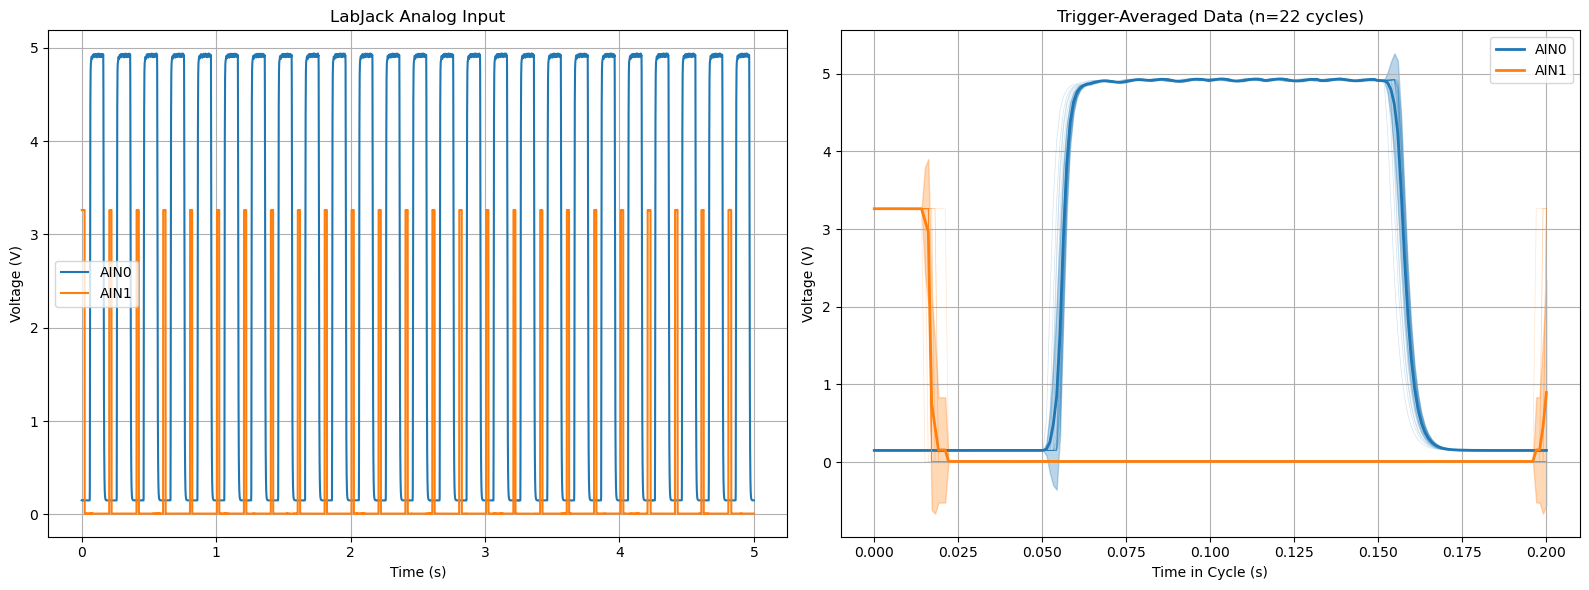

In [23]:
# set stimulus duration in seconds
stimulusDuration = 5

# open as full screen
#pgl.fullScreen(True)
#gl.waitSecs(0.5)

# setup digital output for sync pulse (optional, but recommended for precise timing)
pglLabJack.setupDigitalOutput(channel=0)
pglLabJack.digitalOutput(0)

startTime = pgl.getSecs()
pglLabJack.startAnalogRead(duration=stimulusDuration, channels=['AIN0','AIN1'])

# display flickering stimulus
flushTime = []
temporalFrequency = 5

# start flickering stimulus
flicker = pgl.flicker(pgl, temporalFrequency=temporalFrequency, type='square', phase=0)

#display first frame with a synchronization pulse
pglLabJack.digitalOutput(1)
flicker.display()
flushTime.append(pgl.flush())

while pgl.getSecs() - startTime < stimulusDuration:
    # display the stimulus, which returns True at the beginning of each cycle and False otherwise
    newCycle = flicker.display()
    # set the digital ouptut high if this frame is the beginning of a cycle
    pglLabJack.digitalOutput(newCycle)
    # flush the screen, recording the time of each flush for later analysis
    flushTime.append(pgl.flush())

# stop analog read
time, data = pglLabJack.stopAnalogRead()

# close full screen
pgl.fullScreen(False)

# plot data
#pglLabJack.plotAnalogRead(time, data, cycleLen=1/temporalFrequency)
pglLabJack.plotAnalogRead(time, data, digitalSyncChannel=1, digitalSyncThreshold=2, ignoreInitial=2/temporalFrequency)

Read the gamma table and display it

In [ ]:
# Read the gamma table
gammaTable = pgl.getGammaTable(0)

# display it
plt.plot(gammaTable[0], label='Red')
plt.plot(gammaTable[1], label='Green')
plt.plot(gammaTable[2], label='Blue')
plt.title('Gamma Table')
plt.xlabel('Input Value')
plt.ylabel('Output Value')
plt.legend()
plt.show()

Set gamma table

In [ ]:
# Get the size of the gamma table
displayNumber = 0
tableSize = pgl.getGammaTableSize(displayNumber)
print(f"Gamma table size: {tableSize}")

# create a gamma table
gamma = 1
lin = np.linspace(0, 1, tableSize, dtype=np.float32)
red = lin ** gamma
green = lin ** gamma
blue = lin ** gamma

# set it
pgl.setGammaTable(displayNumber, red, green, blue)

Setup minolta device

- Connect ...

In [ ]:
# initialize minolta calibration device
from pgl import pglCalibrationDeviceMinolta, pglCalibration
pglMinolta = pglCalibrationDeviceMinolta()

Make a measurement

In [ ]:
pglMinolta.measure()

Run a calibration

In [ ]:
# initialize the calibration with the minolta device
pglCal = pglCalibration(pgl, pglMinolta)

# Run the calibration with 8 luminance steps and 2 repeats of each measurement 
pglCal.calibrate(nSteps=8, nRepeats=2)